# Кластеризация. Домашка

## Совсем простая рекомендательная система

На основе оценок аниме, которые ставят пользователи систем типа [MAL](https://myanimelist.net/), можно строить разные кластеры данных:
- кластеры похожих людей. Похожие значит, что эти люди ставят похожие рейтинги аниме.
- кластеры похожих аниме. Похожие значит что люди оценивают их похоже.
- кластеры похожих жанров. Но похожие не в обычном смысле, а в смысле, что люди которые смотрят жанр А любят смотреть жанр Б.

и т.д.

### Полезная литература

- [Лекция 8. Рекомендательный системы](https://www.youtube.com/watch?v=Te_6TqEhyTI&t=4s).
- [Туториал по рекомендательным системам](http://nbviewer.jupyter.org/urls/gitlab.7bits.it/isiganov/ml-course/raw/master/week05/theory/05-01-clustering.ipynb?inline=false)
- [ODS: Обучение без учителя: PCA и кластеризация](https://habrahabr.ru/company/ods/blog/325654/)
- [Интересные алгоритмы кластеризации, часть первая: Affinity propagation](https://habrahabr.ru/post/321216/) и другие статьи цикла
- [Глава 7: кластеризация и визуализация. К. В. Воронцов](http://www.machinelearning.ru/wiki/images/6/6d/Voron-ML-1.pdf)
- [Документация sklearn.clustering](http://scikit-learn.org/stable/modules/clustering.html)
- [K-Means Clustering - The Math of Intelligence. Siraj Raval](https://www.youtube.com/watch?v=9991JlKnFmk) объяснение с программированием KMeans вручную



In [2]:
from sklearn import datasets
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans

from tqdm import tqdm
# from tqdm import tqdm_notebook as tqdm # Раскоментируйте если прогресс бар будет странно работать

%matplotlib inline

# Зафиксируем случайность, чтобы у нас получались одинаковые результаты.
np.random.seed(seed=42)

## Анализ отзывов аниме

Возьмем датасет с рейтингами аниме: https://www.kaggle.com/CooperUnion/anime-recommendations-database  
Кстати, вы можете посмотреть kernels - это jupyter notebooks, в которых другие люди тоже делали что-то с этим датасетом.

```
Anime.csv

anime_id - myanimelist.net's unique id identifying an anime.
name - full name of anime.
genre - comma separated list of genres for this anime.
type - movie, TV, OVA, etc.
episodes - how many episodes in this show. (1 if movie).
rating - average rating out of 10 for this anime.
members - number of community members that are in this anime's "group".


Rating.csv

user_id - non identifiable randomly generated user id.
anime_id - the anime that this user has rated.
rating - rating out of 10 this user has assigned (-1 if the user watched it but didn't assign a rating).
```

In [3]:
colab = False  # True если используте google colab
if colab:
    from google.colab import drive
    drive.mount('/content/drive/')

In [4]:
if colab:
    anime = pd.read_csv('/content/drive/My Drive/Data/anime/anime.csv.zip', index_col='anime_id')
else:
    anime = pd.read_csv('../data/anime/anime.csv.zip', index_col='anime_id')
anime.dropna(inplace=True)
print(anime.shape)
anime.head()

(12017, 6)


,name,genre,type,episodes,rating,members
anime_id,,,,,,
32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [5]:
if colab:
    ratings = pd.read_csv('/content/drive/My Drive/Data/anime/rating.csv.zip')
else:
    ratings = pd.read_csv('../data/anime/rating.csv.zip')
ratings

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1
...,...,...,...
7813732,73515,16512,7
7813733,73515,17187,9
7813734,73515,22145,10
7813735,73516,790,9


Датасет очень большой и грязный. Некоторые действия с этим датасетом будут требовать много оперативной памяти(>6 Гб).

## Подготовка данных

Во первых, в датасете есть много -1. Оценки -1 и 0 на MAL нет. 

Здесь -1 означает что человек посмотрел это аниме, но не выставил оценку.

Такие записи из `ratings` стоит выбросить, так как в нашем случае они особо не помогут. 

Но и не помешают серьезно. Если хотите оставьте их, только нужно заменить все -1 на 0, так как дальше нам понадобится посчитать среднее, а -1 или 0, в отличие от `np.nan`, повлияют на среднее. 

### 1. Избавьтесь от -1

In [6]:
###  Ваш код  ###

ratings = ratings[ratings['rating'] != -1]

ratings

,user_id,anime_id,rating
47,1,8074,10
81,1,11617,10
83,1,11757,10
101,1,15451,10
153,2,11771,10
...,...,...,...
7813732,73515,16512,7
7813733,73515,17187,9
7813734,73515,22145,10
7813735,73516,790,9


## Критерий Шавене (Chauvenet)

[Теория](https://www.youtube.com/watch?v=Fy9pHH3ykPE&list=PLLyuiBK_HOLPfRVN6r9305FKXq1ravbbX)

$$ erfc(\frac{|P_i - mean(P)|}{S_p})  < \frac{1}{2n}$$

$ S_p - отклонение $

Готовой реализации в библиотеках нет, поэтому придется написать самим(но если найдете можете использовать).

### 2. Напишите функцию, которая принимает на вход массив, считает критерий Шавене и возвращает булеву маску.

Функция `erfc` есть в sklearn. 

In [7]:
from scipy.special import erfc

def chauvenet(array):
    ###  Ваш код  ###   
    
    n = len(array)
    mean = np.mean(array)
    std = np.std(array)
    
    criterion = erfc(np.abs(array - mean) / (std * np.sqrt(2)))
    
    mask = criterion >= 1 / (2 * n)
    
    return mask

Для начала давайте посмотрим на таблицу рейтингов.

### 3. Сделайте новую таблицу `count_reviews` где индексами будет `user_id` а значением будет количество просмотренных им аниме.


**Hint** Используйте [groupby](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html) и [count](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.count.html).

In [8]:
###  Ваш код  ### 

count_reviews = ratings.groupby('user_id')['anime_id'].count().reset_index()
count_reviews.columns = ['user_id', 'count_reviews']

count_reviews

,user_id,count_reviews
0,1,4
1,2,1
2,3,92
3,5,459
4,7,343
...,...,...
69595,73512,12
69596,73513,33
69597,73514,1
69598,73515,179


### 4. Используйте функцию chauvenet и найдите все выбросы.

**Hint:** Так как chauvenet возвращает маску используйте оператор `[]` (подробнее смотрите в 1 теории по pandas и numpy).

**Hint:** Используйте [values](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.values.html).

In [9]:
mask = chauvenet(count_reviews['count_reviews'].values)
outlier_users = count_reviews[~mask]['user_id']

outlier_users

214        226
419        446
446        478
900        958
1077      1145
         ...  
67171    70953
67974    71792
69232    73135
69328    73234
69468    73378
Name: user_id, Length: 550, dtype: int64

### 5. Ответьте на вопросы

#### Кого критерий посчитал выбросом?

#### Почему критерий посчитал их выбросом?

#### Нужна ли им вообще рекомендательная система?


**Ответы:**

Критерий определил пользователей с аномально высоким или низким количеством просмотренных аниме

Их значения лежат за пределами нормального распределения, что указывает на малую вероятность их принадлежности к основной выборке

Да, нужна, так как даже активные или пассивные пользователи могут beneficiровать от персонализированных рекомендаций, но подход должен учитывать их уникальное поведение

In [10]:
bad_user_threshold = outlier_users.min()
bad_user_threshold

np.int64(226)

Если все было правильно `bad_user_threshold` больше 500. 

Нужно выбросить всех людей у которых число просмотренных аниме больше или равно `bad_user_threshold`.

### 6. Переименнуйте столбец из таблицы `count_reviews` в `count_reviews` (он там единственный). Соедините `count_reviews` и `ratings` по столбцу `user_id`. И оставьте в `ratings` только тех кто посмотрел меньше `bad_user_threshold`  

In [11]:
###  Ваш код  ### 
count_reviews = count_reviews.rename(columns={'count_reviews': 'count_reviews'})

ratings = ratings.merge(count_reviews, on='user_id', how='left')

ratings = ratings[ratings['count_reviews'] < bad_user_threshold]

ratings

,user_id,anime_id,rating,count_reviews
0,1,8074,10,4
1,1,11617,10,4
2,1,11757,10,4
3,1,15451,10,4
4,2,11771,10,1
...,...,...,...,...
6337236,73515,16512,7,179
6337237,73515,17187,9,179
6337238,73515,22145,10,179
6337239,73516,790,9,2


Осталось все равно слишком много пользователей.

### 7. Удалите из таблицы всех юзеров, у которых количество просмотров меньше медианного значения. То есть мы удалим половину юзеров.

Так как они посмотрели слишком мало, чтобы мы на них могли основывать свои советы.

In [12]:
###  Ваш код  ### 

median_reviews = ratings['count_reviews'].median()

ratings = ratings[ratings['count_reviews'] >= median_reviews]

ratings

,user_id,anime_id,rating,count_reviews
915,11,30,5,110
916,11,43,7,110
917,11,44,7,110
918,11,59,7,110
919,11,61,4,110
...,...,...,...,...
6337234,73515,13659,8,179
6337235,73515,14345,7,179
6337236,73515,16512,7,179
6337237,73515,17187,9,179


In [13]:
# Удалим столбец с просмотрами чтобы не мешал.
    
ratings = ratings.drop(columns=['count_reviews'])

Теперь рассмотрим таблицу `anime`. 


Так же применим критерий шавене.

Искать выбросы стоит по столбцу `rating` или по `members` или по обоим сразу.

### 8. Используйте функцию chauvenet и найдите все выбросы среди аниме. И удалите их.

**Hint** Используйте [drop](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop.html) и [index](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.index.html)

In [14]:
mask_rating = chauvenet(anime['rating'].dropna().values)  # Исключаем NaN для rating
mask_members = chauvenet(anime['members'].values)

combined_mask = mask_rating & mask_members

outlier_anime = anime[~combined_mask].index

outlier_anime

Index([ 5114,  9253, 11061,  4181,   918,  2904,   199, 23273,  1575,     1,
       ...
       28623, 21881, 16742,  2993,  9041,  2476, 13405,  3287, 34476, 20007],
      dtype='int64', name='anime_id', length=150)

In [15]:
anime = anime[combined_mask].reset_index(drop=True)

anime

,name,genre,type,episodes,rating,members
0,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
2,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266
3,Haikyuu!!: Karasuno Koukou VS Shiratorizawa Ga...,"Comedy, Drama, School, Shounen, Sports",TV,10,9.15,93351
4,Ginga Eiyuu Densetsu,"Drama, Military, Sci-Fi, Space",OVA,110,9.11,80679
...,...,...,...,...,...,...
11862,Toushindai My Lover: Minami tai Mecha-Minami,Hentai,OVA,1,4.15,211
11863,Under World,Hentai,OVA,1,4.28,183
11864,Violence Gekiga David no Hoshi,Hentai,OVA,4,4.88,219
11865,Violence Gekiga Shin David no Hoshi: Inma Dens...,Hentai,OVA,1,4.98,175


### 9. Ответье на вопросы

#### Что критерий посчитал выбросом? 

#### Почему критерий посчитал их выбросом? 

#### Можем ли мы как то использовать эти аниме в нашей рекомендательное системе? 

**Ответы:**

Критерий Шавене определил аниме с экстремально высокими или низкими значениями рейтинга (rating) и количества участников (members)

Эти аниме лежат за пределами нормального распределения, что указывает на их аномальность по сравнению с основной массой данных

Да, но с осторожностью: если их данные репрезентативны (например, очень популярные или культовые аниме), их можно включить после дополнительной обработки, чтобы они не искажали общие рекомендации

## Кластеризация по жанрам

Данные о жанре хранятся как строка, разделенная запятой `,` . Но нам нужны сами жанры. Придется поколдовать и разделить эту строку на элементы. 

In [16]:
from itertools import chain
'''
Нам нужна функция flatmap.
Flatmap получает на вход список, на каждом элементе вызывает функцию f, которая возвращает другой список.
В результате получается список списков. В конфе происходит flatten - уплощение списка скписков в один список.
'''
def flatmap(f, items):
    return chain.from_iterable(map(f, items))

# пример использования
list(flatmap(lambda x: [0, x , x*x], [1,2,3,4,5]))
# Первый шаг: [[0, 1, 1], [0, 2, 4], [0, 3, 9], [0, 4, 16], [0, 5, 25]]

[0, 1, 1, 0, 2, 4, 0, 3, 9, 0, 4, 16, 0, 5, 25]

In [17]:
# создаем функцию, которая просто разбивает строку по символу ", " на подстроки
def genre_splitter(genre_names):
    return genre_names.split(", ")

m_uniq = anime['genre'].unique() # смотрим сколько всего уникальных комбинация genres есть в датасете
print("m_uniq[0:10] = {}\nlen= {}\n".format(m_uniq[0:10], len(m_uniq))) # как видим комбинаций очень много, так как там все композиции

genres = set(flatmap(genre_splitter, m_uniq)) # разбиваем все genres на составные части и генерируем один массив из всех жанров. Строим по массиву множество уникальных жанров

genres = list(genres) # множество превращаем в список
print("Genres={}\nlen={}".format(genres, len(genres)))

m_uniq[0:10] = ['Drama, Romance, School, Supernatural'
 'Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen'
 'Comedy, Drama, School, Shounen, Sports' 'Drama, Military, Sci-Fi, Space'
 'Drama, School, Shounen'
 'Adventure, Fantasy, Historical, Mystery, Seinen, Slice of Life, Supernatural'
 'Fantasy, Slice of Life' 'Comedy, Drama, Shounen, Sports'
 'Action, Drama, Historical, Martial Arts, Romance, Samurai'
 'Comedy, Mystery, Romance, School, Sci-Fi, Supernatural']
len= 3182

Genres=['School', 'Super Power', 'Harem', 'Police', 'Music', 'Yuri', 'Fantasy', 'Martial Arts', 'Game', 'Ecchi', 'Shoujo Ai', 'Space', 'Supernatural', 'Josei', 'Cars', 'Shounen', 'Military', 'Historical', 'Yaoi', 'Slice of Life', 'Sports', 'Comedy', 'Romance', 'Sci-Fi', 'Horror', 'Vampire', 'Drama', 'Demons', 'Thriller', 'Shoujo', 'Shounen Ai', 'Psychological', 'Samurai', 'Action', 'Seinen', 'Parody', 'Magic', 'Adventure', 'Mecha', 'Hentai', 'Mystery', 'Kids', 'Dementia']
len=43


### 10. Создадим новую таблицу, где в колонках будет жанр, в строках аниме, а в ячейках 1 если у фильма есть этот жанр и 0 в противном случае.

Такой формат таблиц называтеся one-hot-encoding. Только в нашем случае в каждой строке будет не одна единица, а несколько, так как у аниме как правило несолько жанров.

Уточнение: жанры должны быть индексами столбцов (columns), а id аниме - индексами строк (index)

In [18]:
###  Ваш код  ### 

genre_matrix = pd.DataFrame(0, index=anime.index, columns=genres)

for idx, row in anime.iterrows():
    if isinstance(row['genre'], str): 
        for genre in row['genre'].split(", "):
            if genre in genres:
                genre_matrix.at[idx, genre] = 1

genre_matrix

,School,Super Power,Harem,Police,Music,Yuri,Fantasy,Martial Arts,Game,Ecchi,...,Action,Seinen,Parody,Magic,Adventure,Mecha,Hentai,Mystery,Kids,Dementia
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11862,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
11863,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
11864,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
11865,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


Итак, у нас есть следующие таблицы:
- Жанры аниме - в строчках аниме, в столбцах жанр аниме, а в ячейках 0 или 1.
- Рейтинги - в строчках пользователи, в столбцах id аниме и рейтинг

Нужно получить другую таблицу, в которой в строках будут пользователи, а в столбцах жанры аниме. А в ячейках средняя оценка жанра этим пользователем.

Средняя оценка жанра вычисляется следующим образом: берём все отзывы пользователя. Группируем все его отзывы по жанрам и считаем средний рейтинг, который он ставит аниме с данным жанром.

Выполним следущие шаги.

### 11. Соединим две таблицы:<br>
1. жанры по каждому аниме<br>
2. оценки аниме от людей. Кстати, один человек мог посмотреть 1 аниме или 100, но не все!<br>

Получим таблицу, где строк будет N*M штук, где N - количество юзеров и M - количество аниме

In [19]:
###  Ваш код  ### 

df = ratings.merge(genre_matrix, left_on='anime_id', right_index=True)

df

,user_id,anime_id,rating,School,Super Power,Harem,Police,Music,Yuri,Fantasy,...,Action,Seinen,Parody,Magic,Adventure,Mecha,Hentai,Mystery,Kids,Dementia
915,11,30,5,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
916,11,43,7,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
917,11,44,7,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
918,11,59,7,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
919,11,61,4,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6337218,73515,11741,9,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
6337219,73515,11751,6,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
6337220,73515,11757,9,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
6337221,73515,11759,8,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


С такой таблицей `(N*M) * G` вы всё еще не можем работать.  
### 12. Сгруппируем строки по пользователям (колонка `userId`).  В группах посчитаем среднюю оценку на жанр. А если пользователь не смотрел фильм, то поставим ему `-1` в соответсвующую ячейку.
Чтобы посчитать среднее(mean) без учета непросмотренных аниме замените все `0` на `np.NaN`

In [20]:
###  Ваш код  ### 

df = df.set_index('user_id')
df[df == 0] = np.nan
df = df.groupby('user_id').mean().fillna(-1)

df.head()

,anime_id,rating,School,Super Power,Harem,Police,Music,Yuri,Fantasy,Martial Arts,...,Action,Seinen,Parody,Magic,Adventure,Mecha,Hentai,Mystery,Kids,Dementia
user_id,,,,,,,,,,,,,,,,,,,,,
11,2066.615385,7.175824,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0
14,6595.766234,7.181818,1.0,1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0
21,3671.772277,7.891089,1.0,1.0,1.0,1.0,1.0,-1.0,1.0,-1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0
29,3123.411765,6.911765,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0
44,5859.560976,7.768293,1.0,1.0,-1.0,-1.0,1.0,-1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0


Так как некоторые пользователи не смотрели ничего из некоторых жанров, в данных осталось много `np.NaN`
### 13. Заполните все NaN на -1

**Hint** [fillna](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.fillna.html)

In [21]:
###  Ваш код  ### 
df = df.fillna(-1)

df.head()

,anime_id,rating,School,Super Power,Harem,Police,Music,Yuri,Fantasy,Martial Arts,...,Action,Seinen,Parody,Magic,Adventure,Mecha,Hentai,Mystery,Kids,Dementia
user_id,,,,,,,,,,,,,,,,,,,,,
11,2066.615385,7.175824,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0
14,6595.766234,7.181818,1.0,1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0
21,3671.772277,7.891089,1.0,1.0,1.0,1.0,1.0,-1.0,1.0,-1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0
29,3123.411765,6.911765,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0
44,5859.560976,7.768293,1.0,1.0,-1.0,-1.0,1.0,-1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0


Прежде чем начать обучать kMeans...

### 14. Отмасштабируйте признаки.

Как мы знаем по лекции, метрическим алгоритмам, одним из которых и является kMeans, лучше подавать на вход данные одного масштаба.  Этим и занимается метод MinMaxScaler из sklearn.

[Документация](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html)

Алгоритм его работы:
```
X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
X_scaled = X_std * (max - min) + min
```

In [24]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)
scaled_data

array([[0.17662007, 0.64161946, 1.        , ..., 1.        , 1.        ,
        0.        ],
       [0.66947498, 0.64238009, 1.        , ..., 1.        , 1.        ,
        0.        ],
       [0.35129066, 0.73238471, 1.        , ..., 1.        , 1.        ,
        0.        ],
       ...,
       [0.45813393, 0.75735161, 1.        , ..., 1.        , 1.        ,
        1.        ],
       [0.43196205, 0.64108873, 1.        , ..., 1.        , 1.        ,
        1.        ],
       [0.37354377, 0.81938531, 1.        , ..., 1.        , 1.        ,
        1.        ]], shape=(11170, 45))

### 15.Натренируйте kMeans с 10 кластерами на полученных данных

In [25]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=10, random_state=42)
clusters = kmeans.fit_predict(scaled_data)
clusters

array([7, 5, 2, ..., 0, 6, 0], shape=(11170,), dtype=int32)

### 16. Нарисуйте на графике центры кластеров нашего датасета оценок фильмов.

В нем будет 10 строчек - 10 кластеров. И 43 столбцов - 43 жанров фильмов.

Из графика мы поймем какие жанры обычно смотрят вместе. По сути мы получили кластеры предпочтений людей.

**Hint** [Heatmap](https://seaborn.pydata.org/generated/seaborn.heatmap.html)

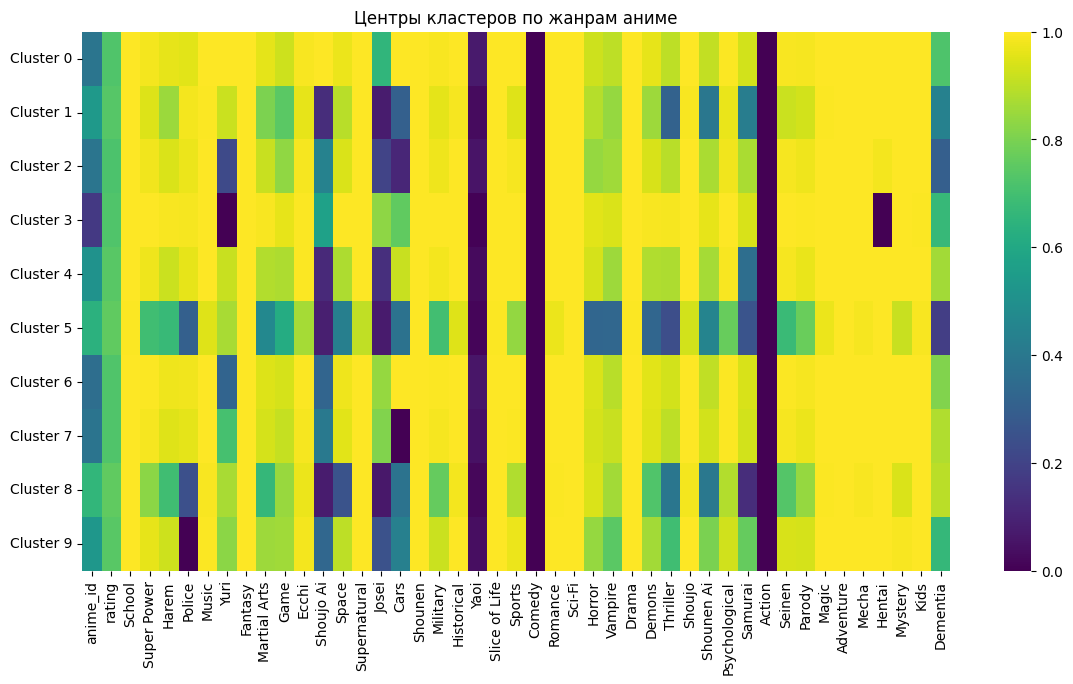

In [26]:
###  Ваш код  ### 

centers = kmeans.cluster_centers_
plt.figure(figsize=(14, 7))
sns.heatmap(centers, cmap='viridis', yticklabels=[f'Cluster {i}' for i in range(10)], xticklabels=df.columns)
plt.title('Центры кластеров по жанрам аниме')
plt.show()

# Как выбрать нужное число кластеров

Такие методы как KMeans, Spectral clustering, Ward hierarchical clustering, Agglomerative clustering требуют количество кластеров как параметр. Это так называемый гипер-параметр, и его должен подбирать человек. Но на что человеку опираться при выборе? На некоторый функционал "качества"!

Вспомним идею кластеризации:
- минимизация внутрикластерного расстояния
- максимизация межкластерного расстояния

Другими словами - кучки кучнее и дальше друг от друга.

Логично, что мы хотим, чтобы точки распологались кучно возле центров своих кластеров. Но вот незадача: минимум такого функционала будет достигаться тогда, когда кластеров столько же, сколько и точек (то есть каждая точка – это кластер из одного элемента). Для решения этого вопроса (выбора числа кластеров) часто пользуются такой эвристикой: выбирают то число кластеров, начиная с которого описанный функционал $ J(C) $ падает "уже не так быстро". Или более формально: $$ D(k) = \frac{|J(C_k) - J(C_{k+1})|}{|J(C_{k-1}) - J(C_k)|}  \rightarrow \min\limits_k $$

Где, в случае kMeans $$ J(C) = \sum_{k=1}^K\sum_{i~\in~C_k} ||x_i - \mu_k|| \rightarrow \min\limits_C,$$ - сумма квадратов расстояний от точек до центроидов кластеров, к которым они относятся

#### Эта ячейка может выполнятся долго!

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:05<00:00,  5.49it/s]


Text(0, 0.5, '$J(C_k)$')

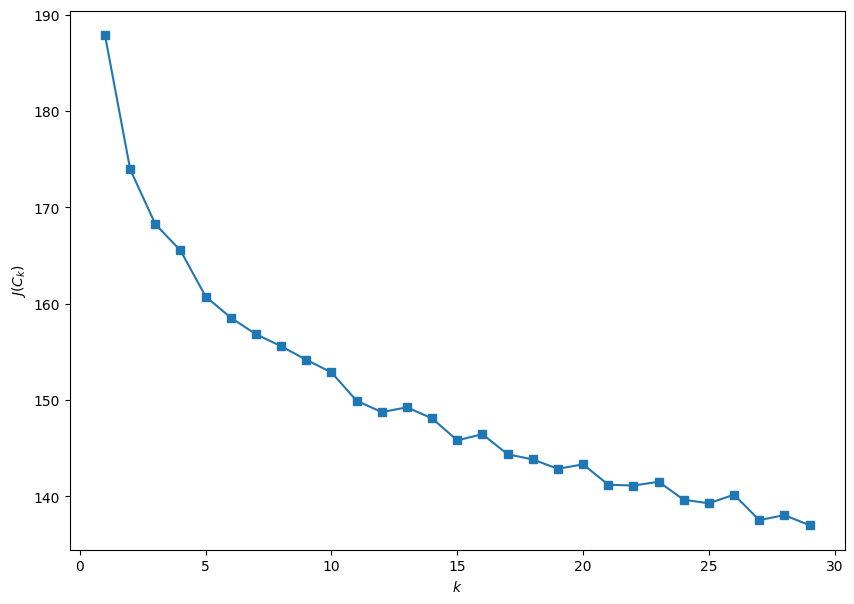

In [27]:
inertia = []
N = 30
for k in tqdm(range(1, N)):
    kmeans = KMeans(n_clusters=k).fit(scaler.fit_transform(df))
    inertia.append(np.sqrt(kmeans.inertia_))
plt.figure(figsize=(10,7))
plt.plot(range(1, N), inertia, marker='s');
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$')

## Коэффициент силуэта

Данный коэффициент не предполагает знания истинных меток объектов, и позволяет оценить качество кластеризации, используя только саму (неразмеченную) выборку и результат кластеризации. 

Сначала силуэт определяется отдельно для каждого объекта. Обозначим через $a$ - среднее расстояние от данного объекта до объектов из того же кластера, через $b$ - среднее расстояние от данного объекта до объектов из ближайшего кластера (отличного от того, в котором лежит сам объект). Тогда силуэтом данного объекта называется величина: $$s = \frac{b - a}{\max(a, b)}.$$ Силуэтом выборки называется средняя величина силуэта объектов данной выборки. Таким образом, силуэт показывает, насколько среднее расстояние до объектов своего кластера отличается от среднего расстояния до объектов других кластеров. Данная величина лежит в диапазоне $[-1, 1]$. Значения, близкие к -1, соответствуют плохим (разрозненным) кластеризациям, значения, близкие к нулю, говорят о том, что кластеры пересекаются и накладываются друг на друга, значения, близкие к 1, соответствуют "плотным" четко выделенным кластерам. Таким образом, чем больше силуэт, тем более четко выделены кластеры, и они представляют собой компактные, плотно сгруппированные облака точек.

С помощью силуэта можно выбирать оптимальное число кластеров $k$ (если оно заранее неизвестно) - выбирается число кластеров, максимизирующее значение силуэта. В отличие от предыдущих метрик, силуэт зависит от формы кластеров, и достигает больших значений на более выпуклых кластерах, получаемых с помощью алгоритмов, основанных на восстановлении плотности распределения.

#### Эта ячейка может выполняться долго!

In [28]:
from sklearn.metrics import silhouette_score, silhouette_samples

def draw_sil_score(X, range_n_clusters=[2, 3, 4, 5, 6, 10, 12, 13, 20]):
    scores = []
    for n_clusters in tqdm(range_n_clusters):
        clusterer = KMeans(n_clusters=n_clusters, random_state=10)
        cluster_labels = clusterer.fit_predict(X)
        silhouette_avg = silhouette_score(X, cluster_labels)
        scores.append(silhouette_avg)
    plt.plot(range_n_clusters, scores)
    return range_n_clusters[np.argmax(scores)]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 28/28 [01:19<00:00,  2.84s/it]


2

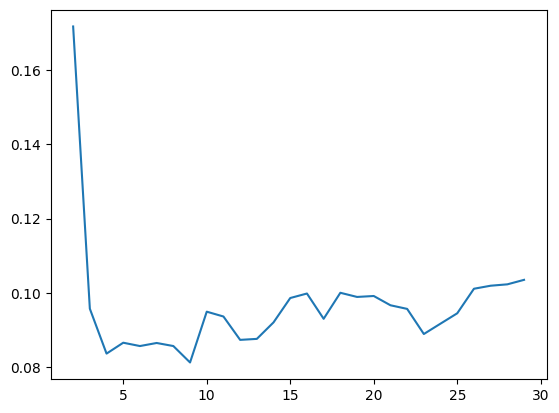

In [29]:
draw_sil_score(scaler.fit_transform(df), range(2, 30))

### 17. Выберите количество кластеров `k` по методам выше. Натренируйте kMeans и снова нарисуйте heatmap.

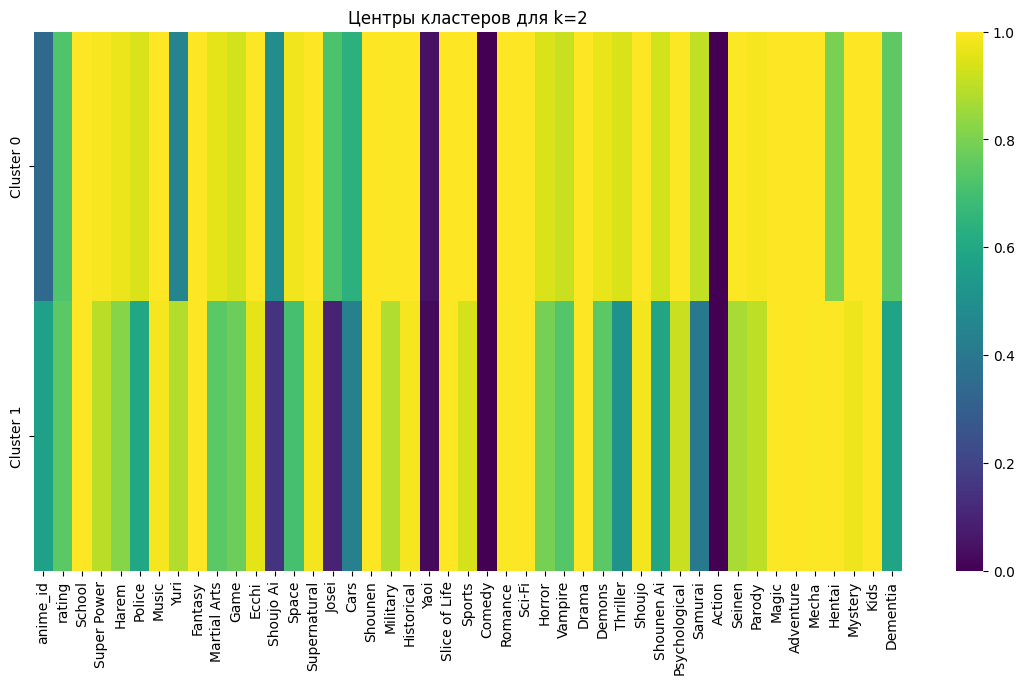

In [33]:
kmeans_optimal = KMeans(n_clusters=2, random_state=42)
clusters_optimal = kmeans_optimal.fit_predict(scaled_data)

centers_optimal = kmeans_optimal.cluster_centers_
plt.figure(figsize=(14, 7))
sns.heatmap(centers_optimal, cmap='viridis', yticklabels=[f'Cluster {i}' for i in range(2)], xticklabels=df.columns)
plt.title(f'Центры кластеров для k={2}')
plt.show()

### 18. Порекомендуйте что-нибудь абстрактному пользователю. 
Это можно сделать разными способами. Как это сделать подумайте сами. 

Если затрудняетесь реализовать это в коде, распишите словами как вы бы это сделали.

Возможные варианты решения:
 * в каждом кластере отсортировать жанры по тому, насколько жанр важен. 
 * взять каждый кластер -> получить все аниме, которые смотрят в этом кластере -> отсортировать по рейтину.



Мы могли бы рассматривать каждый кластер как представление групп пользователей с разными интересами, которые смотрят эти жанры. Поэтому было бы лучше показывать разные шоу по важности в своем кластере, а не только по популярности

In [39]:
###  Ваш код или рассуждение или все вместе ###

optimal_k = 2
genre_importance = pd.DataFrame(index=range(optimal_k), columns=genres) 
for i in range(optimal_k):
    cluster_data = df[clusters_optimal == i]
    genre_importance.iloc[i] = cluster_data[genres].mean()  

sorted_genres = genre_importance.apply(lambda x: x.sort_values(ascending=False).index.tolist(), axis=1)

recommended_genres = sorted_genres[0][:5] 
print(f"Рекомендуемые жанры:\n{recommended_genres}")

anime_in_recommended_genres = anime[anime['genre'].apply(lambda x: any(genre in x for genre in recommended_genres))]
top_anime_names = anime_in_recommended_genres['name'].head(5)  
print(f"Рекомендуемые аниме:\n{top_anime_names}")

Рекомендуемые жанры:
['School', 'Supernatural', 'Mecha', 'Adventure', 'Magic']
Рекомендуемые аниме:
0                                       Kimi no Na wa.
3    Haikyuu!!: Karasuno Koukou VS Shiratorizawa Ga...
7                                       Koe no Katachi
8                              Haikyuu!! Second Season
9                        Mushishi Zoku Shou 2nd Season
Name: name, dtype: object


### Extra. Попробуйте как-нибудь улучшить эту рекомендашку. Приведите код или рассуждения на эту тему.

Если писать код, то можно:
 * каждому жанру присвоить свой вес, так как одних жанров сильно много и у них разная смысловая нагрузка. Комедии и экшн встречаются очень часто и врядли кто-то только из-за этих жанров будет смотреть аниме.
 * предсказывать не по жанрам, а по аниме. Там получится очень большая размерность, так как нужно сделать one-hot-encoding по аниме, но может это даст лучше результат(спойлер: нет). (И для этого надо сделать 4 join'а, что, возможно, убьет ваш компьютер или/и мозг)

In [41]:
from sklearn.feature_extraction.text import TfidfVectorizer

anime['genre_text'] = anime['genre'].apply(lambda x: ' '.join(x.split(', ')))

vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(anime['genre_text'])
feature_names = vectorizer.get_feature_names_out()

genre_weights = {genre: weight for genre, weight in zip(feature_names, tfidf_matrix.mean(axis=0).A1)}

weighted_genre_importance = pd.DataFrame(index=range(optimal_k), columns=genres)
for i in range(optimal_k):
    cluster_data = df[clusters_optimal == i]
    weighted_means = []
    for genre in genres:
        if genre in genre_weights:
            weighted_mean = cluster_data[genre].mean() * genre_weights[genre]
        else:
            weighted_mean = 0
        weighted_means.append(weighted_mean)
    weighted_genre_importance.iloc[i] = weighted_means

sorted_weighted_genres = weighted_genre_importance.apply(lambda x: x.sort_values(ascending=False).index.tolist(), axis=1)

recommended_weighted_genres = sorted_weighted_genres[0][:5] # top 5 genres
print(f"Рекомендуемые жанры с учетом весов:\n{recommended_weighted_genres}")

anime_in_recommended_weighted_genres = anime[anime['genre'].apply(lambda x: any(genre in x for genre in recommended_weighted_genres))]
top_anime_names = anime_in_recommended_weighted_genres['name'].head(5)  # top 5 anime
print(f"Рекомендуемые аниме:\n{top_anime_names}")

Рекомендуемые жанры с учетом весов:
['School', 'Samurai', 'Horror', 'Vampire', 'Drama']
Рекомендуемые аниме:
0                                       Kimi no Na wa.
1                                             Gintama°
2                                        Gintama&#039;
3    Haikyuu!!: Karasuno Koukou VS Shiratorizawa Ga...
4                                 Ginga Eiyuu Densetsu
Name: name, dtype: object
